In [1]:
import os
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
from pyspark.sql import Row, SparkSession
from pyspark.sql.functions import *

In [3]:
path = "data/"
file_name = ['chicago_2019.csv', 'chicago_2020.csv', 'chicago_2021.csv', 'chicago_2022.csv']
filenames =[path + file for file in file_name]
#print(filenames)

""" 
    Read Me: Basic File Merger, to combine the 2019-2022 census data
    Requires: file path list
"""
def fileMerger(path):
    df1 = pd.read_csv(path[0])
    df2 = pd.read_csv(path[1])
    df_merged = df1.merge(df2, how='outer')
    for file in path[2:]:
        temp = pd.read_csv(file)
        df_merged = df_merged.merge(temp, how='outer')
    return df_merged

df = fileMerger(filenames)

In [4]:
df.shape

(922148, 22)

In [5]:
df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,24368,JC103046,01/03/2019 02:37:00 PM,050XX S INDIANA AVE,0110,HOMICIDE,FIRST DEGREE MURDER,AUTO,False,False,...,3.0,38.0,01A,1178455.0,1871575.0,2019,09/01/2022 03:42:17 PM,41.802909,-87.621048,"(41.802908524, -87.62104831)"
1,24369,JC103046,01/03/2019 02:37:00 PM,050XX S INDIANA AVE,0110,HOMICIDE,FIRST DEGREE MURDER,AUTO,False,False,...,3.0,38.0,01A,1178455.0,1871575.0,2019,09/01/2022 03:42:17 PM,41.802909,-87.621048,"(41.802908524, -87.62104831)"
2,24370,JC105864,01/05/2019 04:23:00 PM,012XX N ADA ST,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,True,False,...,2.0,24.0,01A,1167119.0,1908611.0,2019,09/01/2022 03:42:17 PM,41.904789,-87.661560,"(41.904788891, -87.66155984)"
3,24371,JC106397,01/06/2019 12:10:00 AM,014XX W 71ST PL,0110,HOMICIDE,FIRST DEGREE MURDER,APARTMENT,True,False,...,17.0,67.0,01A,1168078.0,1857336.0,2019,09/19/2022 03:41:05 PM,41.764065,-87.659515,"(41.764064647, -87.659514616)"
4,24372,JC107385,01/06/2019 10:23:00 PM,060XX W 63RD ST,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,True,False,...,13.0,64.0,01A,1137054.0,1862130.0,2019,09/01/2022 03:42:17 PM,41.777831,-87.773112,"(41.77783091, -87.773112387)"


In [6]:
# Converting Community Area Code to an Community Name
"""
This allows us to explore data much effectively, being able
to scrape further information outside of just a code, such as
exploring real estate property indices in each community, and
make inferences regarding average home sale price and its corresponding community.
"""
import requests
url = "https://www.chicagotribune.com/2002/12/04/chicago-communities-17/"
text = requests.get(url).text

In [7]:
tables = pd.read_html(url)
print("Found {} tables in {}".format(len(tables), url))

Found 4 tables in https://www.chicagotribune.com/2002/12/04/chicago-communities-17/


In [8]:
hash = {"Community Area" : ["nan", "nan"], "Community Name": ["NaN", "NaN"]}

In [9]:
community = tables[1]

for item in (community):
    # community index
    if(item == 0 or item == 2):
        for i in range(len(community[item])):
                community[item] = community[item].astype(float)
                hash['Community Area'].append(community[item][i])
    if(item == 1 or item == 3):
        for i in range(len(community[item])):
                community[item] = community[item].astype(str)
                #print(community[item][i])
                hash['Community Name'].append(community[item][i])


In [10]:
def applyName(x):
    for item in range(len(hash["Community Area"])):
        if x == hash["Community Area"][item]:
            return hash["Community Name"][item]
df["Community Name"] = df['Community Area'].apply(applyName)

In [11]:
df.index = pd.DatetimeIndex(df.Date)

In [12]:
df['Month'] = df.index.month
df['DayOfWeek'] = df.index.dayofweek
df['DayOfMonth'] = df.index.day
df['DayOfYear'] = df.index.dayofyear
df['WeekOfMonth'] = df.DayOfMonth.apply(lambda x: (x-1) // 7+1)

In [13]:
import math
dayOfYear = list(df.index.dayofyear)
weekOfYear = [math.ceil(x / 7) for x in dayOfYear]
df['weekOfYear'] = weekOfYear

<function matplotlib.pyplot.show(close=None, block=None)>

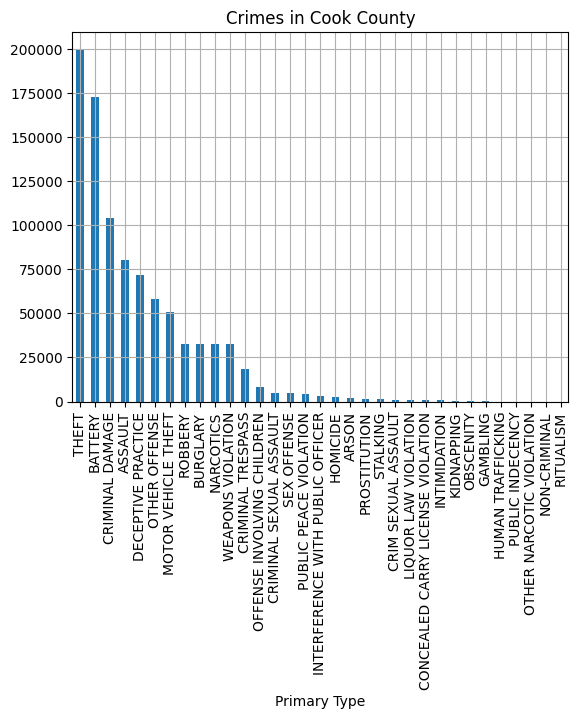

In [14]:
df['Primary Type'].value_counts().plot.bar()
plt.title("Crimes in Cook County")
plt.grid(True)
plt.show

We can clearly observe that crime categorized as "THEFT" has the highest occurences in Chicago, Cook County. 

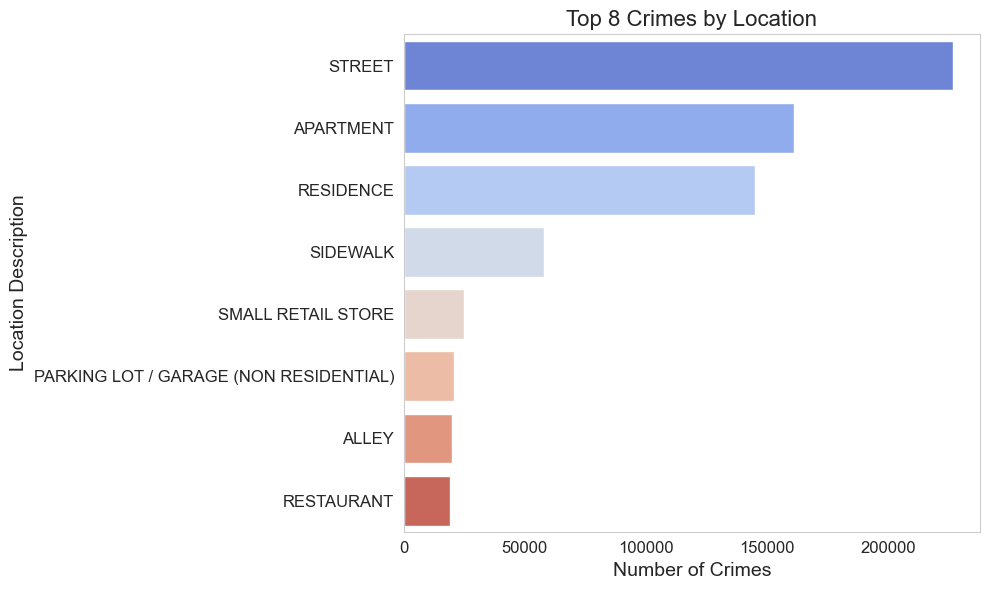

In [15]:
top_locations = df['Location Description'].value_counts().head(8)
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
palette = sns.color_palette("coolwarm", len(top_locations))
sns.barplot(x=top_locations.values, y=top_locations.index, palette=palette)
# Customize the visualization
plt.title('Top 8 Crimes by Location', fontsize=16)
plt.xlabel('Number of Crimes', fontsize=14)
plt.ylabel('Location Description', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x')
plt.tight_layout()
plt.show()

Crimes are most frequently occuring in areas of residence within Chicago, Cook County. There could potentially be an observable correlation between crimes occuring within domestic cases, rather than by random occurence. Might look into investigating. 

In [16]:
def bar_plot(data, col):
    if data[col].dtype in ['object']:
        fig, ((axis1, axis2)) = plt.subplots(2, 1, figsize=(15,20))
        plot = df[['Arrest', col]].dropna()
        df1 = plot.loc[plot['Arrest'] == True]
        df2 = plot.loc[plot['Arrest'] == False]
        df1.groupby(col)[col].count().nlargest(10).plot(kind='barh', ax=axis1, title='Arrest: ' + col) 
        df2.groupby(col)[col].count().nlargest(10).plot(kind='barh', ax=axis2, title='NO Arrest: ' + col) 


In [17]:
def bar_plot(df, col, title_prefix=''):
    
    # CHECK TO SEE IF THE COLUMN IS PRESENT >> 
    if col in df.columns and df[col].dtype == 'object':
        plot_data = df[['Arrest', col]].dropna()
        sns.set_style("whitegrid")
        fig, axes = plt.subplots(2, 1, figsize=(10, 12))
        for i, arrest_status in enumerate([True, False]):
            temp_df = plot_data[plot_data['Arrest'] == arrest_status]
            count_series = temp_df[col].value_counts().nlargest(10)
            palette = sns.color_palette("rocket", len(count_series))
            sns.barplot(y=count_series.index, x=count_series.values, ax=axes[i], palette=palette)
            axes[i].set_title(f"{title_prefix}{'Arrest' if arrest_status else 'No Arrest'}: {col}")
            axes[i].set_xlabel('Count')
            axes[i].set_ylabel(col)
        plt.tight_layout()
        plt.show()

    else:
        print(f"Column '{col}' is not present or not categorical.")


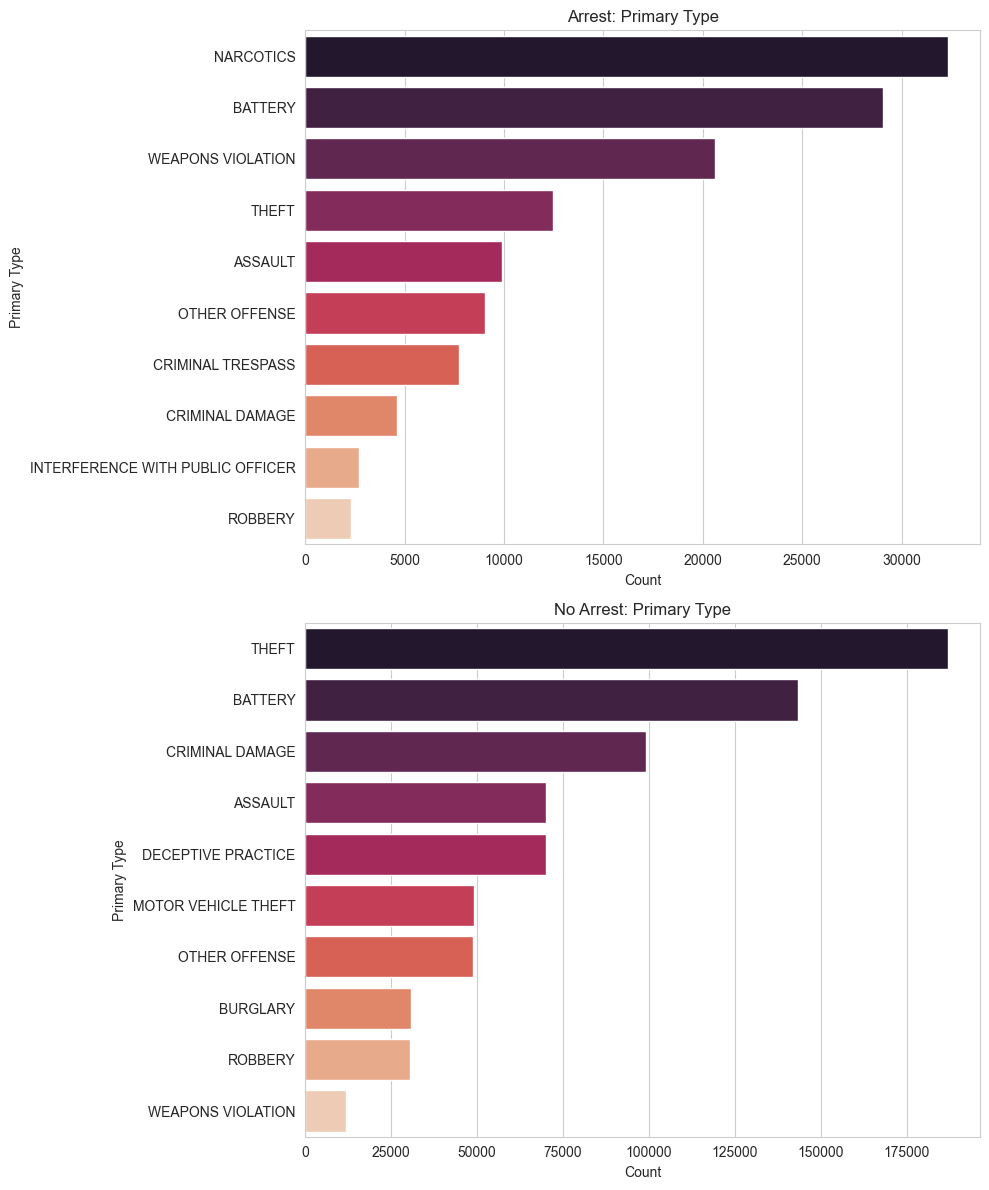

In [18]:
bar_plot(df, 'Primary Type')

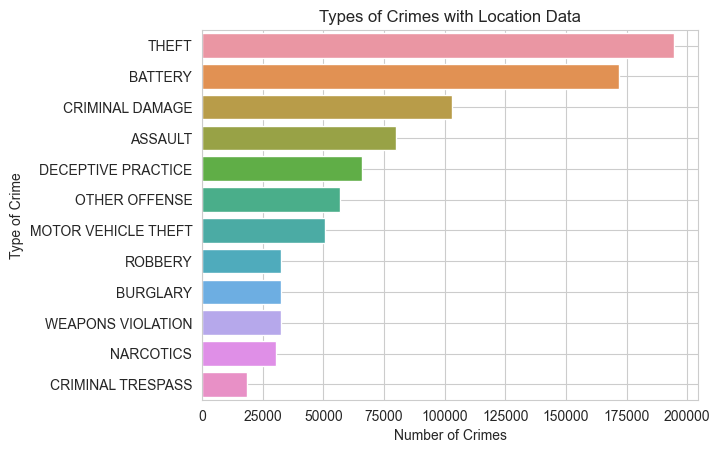

In [19]:
is_crimes = df[df["Location"].notnull()]
crime_counts = is_crimes.groupby("Primary Type").size().sort_values(ascending=False).head(12)
crime_counts_df = crime_counts.reset_index(name='Number of Crimes')
fig = sns.barplot(x="Number of Crimes", y="Primary Type", data=crime_counts_df)
plt.title("Types of Crimes with Location Data")
plt.xlabel("Number of Crimes")
plt.ylabel("Type of Crime")
plt.grid(True)
plt.show()

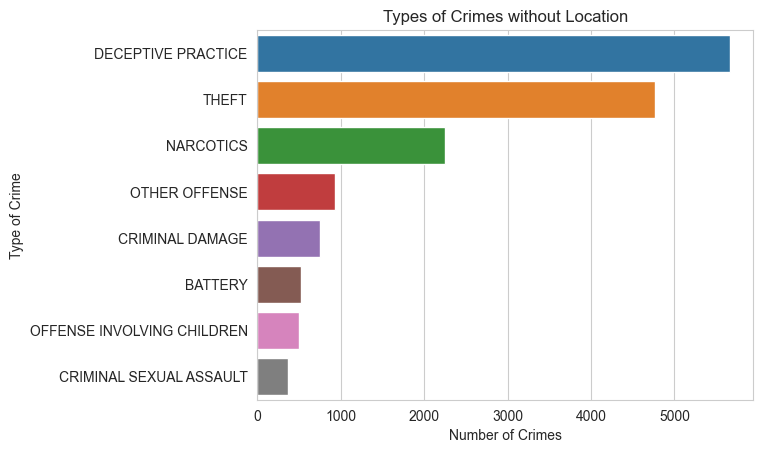

In [20]:
not_crime = df[df["Location"].isnull()]
crime_counts = not_crime.groupby("Primary Type").size().sort_values(ascending=False).head(8)
crime_counts_df = crime_counts.reset_index(name='Number of Crimes')
fig = sns.barplot(x="Number of Crimes", y="Primary Type", data=crime_counts_df)
plt.title("Types of Crimes without Location")
plt.xlabel("Number of Crimes")
plt.ylabel("Type of Crime")
plt.show()

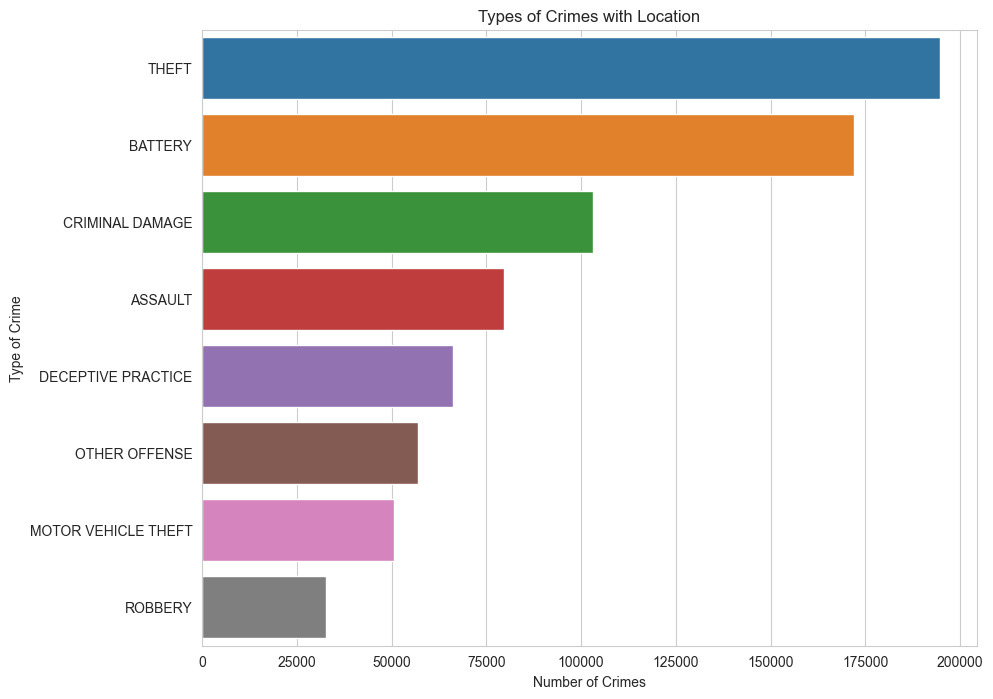

In [21]:
not_crime = df[df["Location"].isnull()==False]
not_crime = df[df["Location"].isnull()==False]
not_crime = not_crime.groupby("Primary Type").size().sort_values(ascending=False).reset_index(name='counts').head(8)
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the figure size as needed
sns.barplot(data=not_crime, y="Primary Type", x="counts", ax=ax)
plt.title("Types of Crimes with Location")
plt.xlabel("Number of Crimes")
plt.ylabel("Type of Crime")
plt.show()

* Deceptive Practice
It's the crime where a person commits a practice when they have the intent to defraud another person and does any of the follow:
- Knowingly cause another person, by threat or deception, to execute a document/payment
- Dispose the victim of a property or incur a pecuniary oblogation
> This in turn makes sense, that it wouldn't have a location, given that most of these crimes are reported through online documentation, an idea would be that the crime occurs in wards with an higher overall income, who may be more suspect to being targeted by these fraudulent malpractices. 

In [22]:
df['Y Coordinate']

Date
2019-01-03 14:37:00    1871575.0
2019-01-03 14:37:00    1871575.0
2019-01-05 16:23:00    1908611.0
2019-01-06 00:10:00    1857336.0
2019-01-06 22:23:00    1862130.0
                         ...    
2022-03-11 21:00:00          NaN
2022-12-20 14:15:00          NaN
2020-04-23 08:00:00          NaN
2020-01-01 00:00:00          NaN
2022-09-01 10:00:00          NaN
Name: Y Coordinate, Length: 922148, dtype: float64

Text(0.5, 1.0, 'Crime Distribution per District')

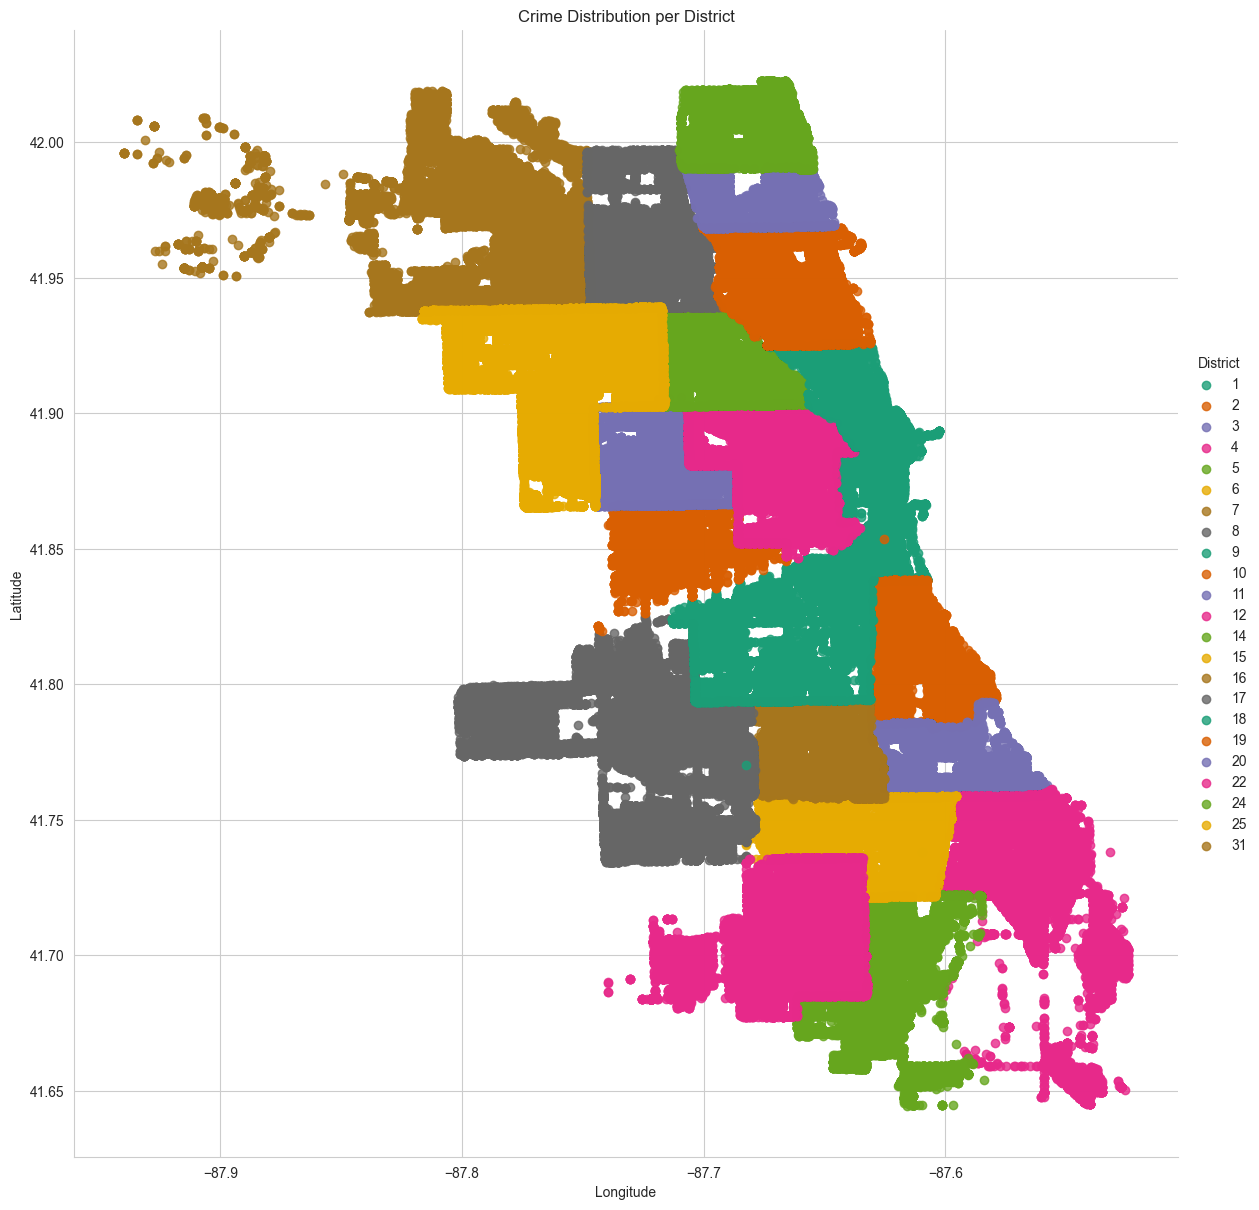

In [23]:
filtered_df = df[(df['Longitude'] > -88) & (df['Longitude'] < -87) & (df['Latitude'] > 41) & (df['Latitude'] < 43)]
sns.lmplot(data=filtered_df, 
           x= 'Longitude', 
           y= 'Latitude',
           fit_reg=False,
           hue="District",
           palette='Dark2',
           height=12,
           ci=2)
ax = plt.gca()
ax.set_title("Crime Distribution per District")

Text(0.5, 1.0, 'Crime Distribution per District')

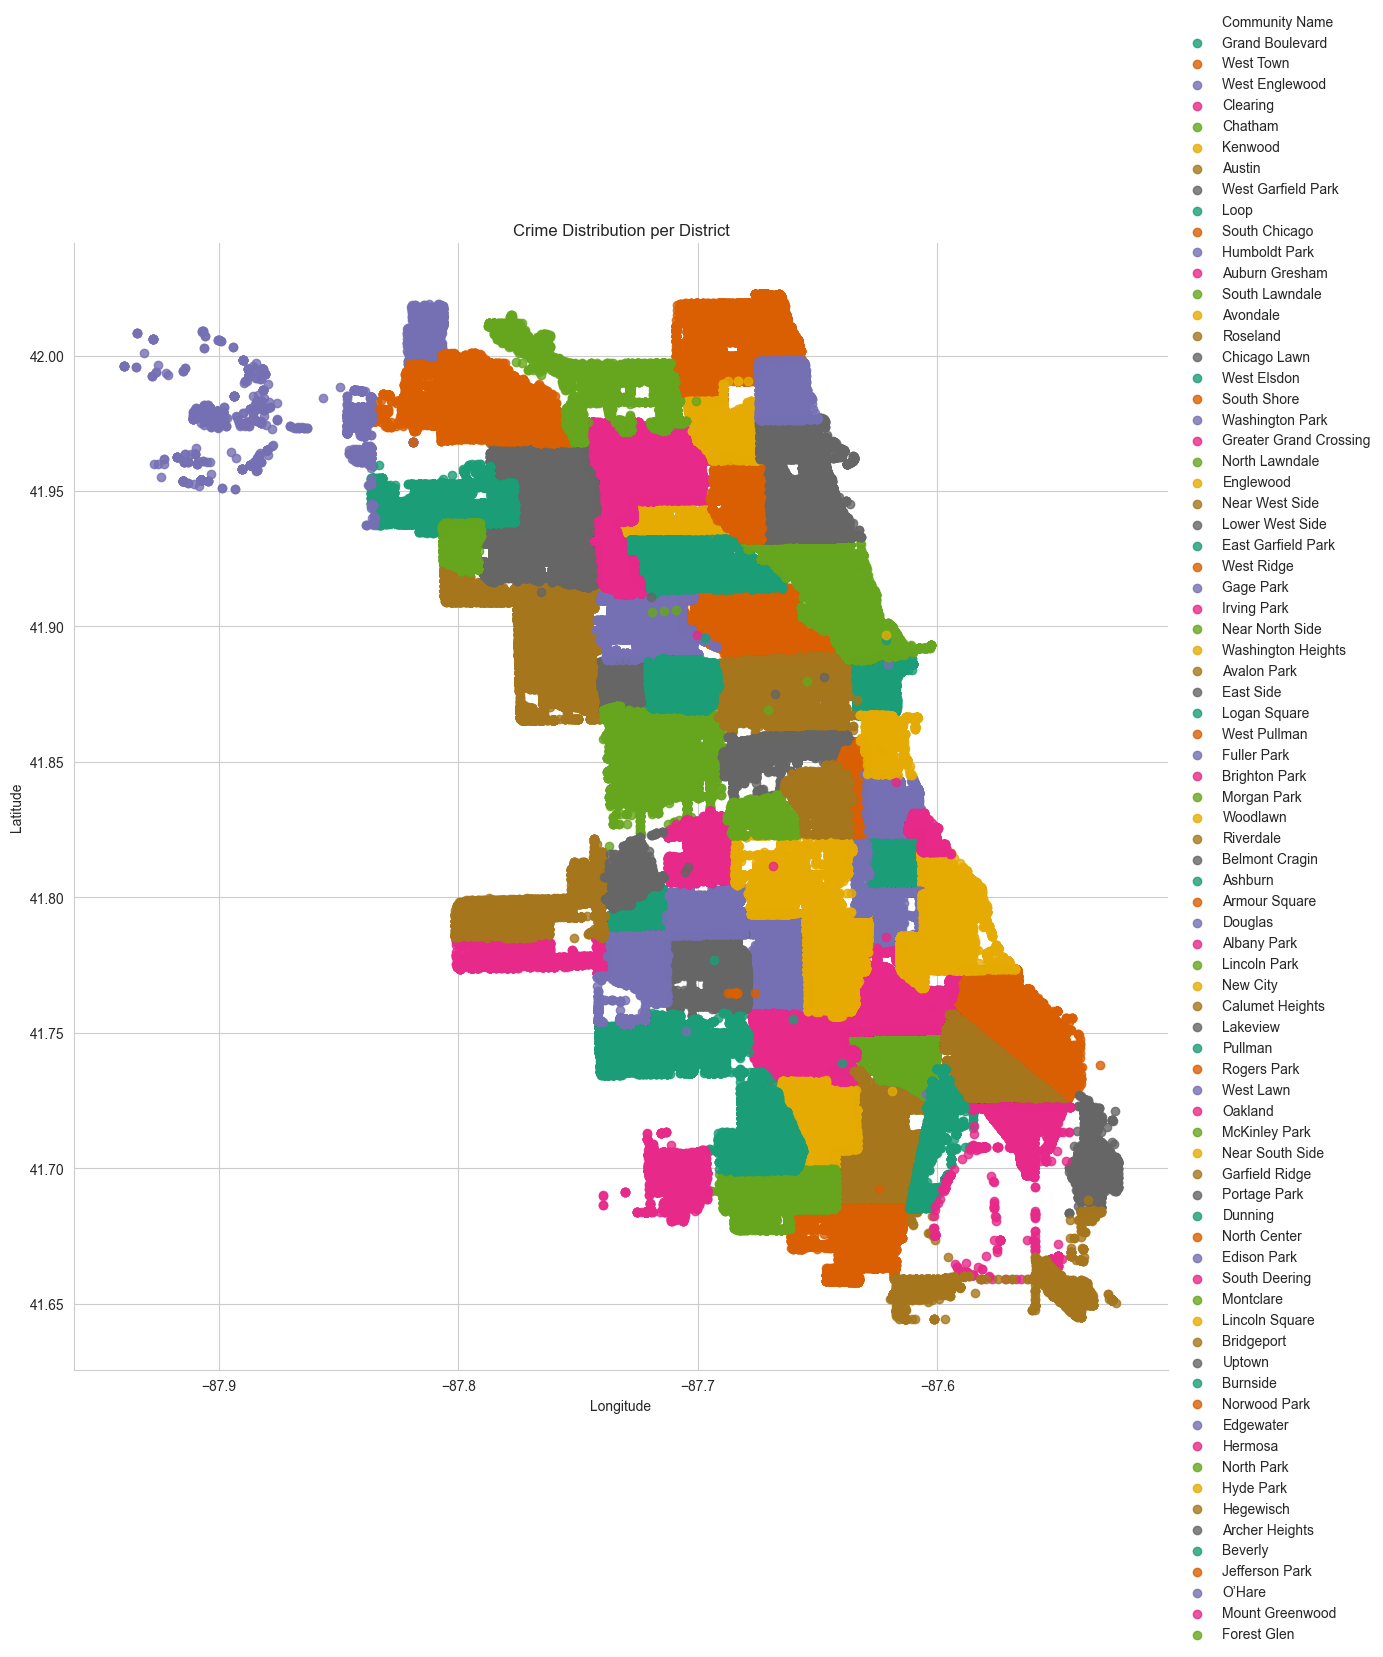

In [28]:
filtered_df = df[(df['Longitude'] > -88) & (df['Longitude'] < -87) & (df['Latitude'] > 41) & (df['Latitude'] < 43)]
sns.lmplot(data=filtered_df, 
           x= 'Longitude', 
           y= 'Latitude',
           fit_reg=False,
           hue="Community Name",
           palette='Dark2',
           height=12,
           ci=2)
ax = plt.gca()
ax.set_title("Crime Distribution per Community Name")

**Data Preprocessing**

In [25]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [26]:
df.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location', 'Community Name', 'Month', 'DayOfWeek', 'DayOfMonth',
       'DayOfYear', 'WeekOfMonth', 'weekOfYear'],
      dtype='object')